# Load Data

In [1]:
# Load Pandas library and load the dataset
import pandas as pd
df = pd.read_csv("data-employee-recruitment.csv")

In [2]:
df.head()

,enrollee_id,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,14569,0.704,Male,Has relevent experience,Full time course,Graduate,STEM,2,50-99,Pvt Ltd,2,71,1.0
1,10557,0.594,Female,Has relevent experience,Full time course,Masters,STEM,9,50-99,Early Stage Startup,never,217,1.0
2,14095,0.596,Male,Has relevent experience,Part time course,Graduate,Humanities,2,100-500,Pvt Ltd,2,12,1.0
3,16300,0.614,Male,Has relevent experience,Full time course,Masters,STEM,4,50-99,Pvt Ltd,1,20,1.0
4,14550,0.534,Male,No relevent experience,Full time course,Graduate,STEM,<1,50-99,Early Stage Startup,1,52,1.0


A company is looking for potential candidates from a pool of training program attendants. The dataset contains attendant background (demographics, current company, i.e., data features) and whether he or she is looing for a job change (data label). The company wants to build a prediction model using this dataset. Here follows the data dictionary:

* enrollee_id : unique ID for candidate
* city_development_index : developement index of the city (scaled)
* gender: gender of candidate
* relevent_experience: relevant experience of candidate
* enrolled_university: type of university course enrolled if any
* education_level: education level of candidate
* major_discipline: education major discipline of candidate
* experience: candidate's total experience in years
* company_size: number of employees in the current company of candidate
* company_type : Type of current employer
* last_new_job: difference in years between previous job and current job
* training_hours: training hours completed
* target value: 0 – not looking for job change, 1 – looking for a job change

# EDA

In [8]:
data = df.copy()

data.drop(columns=["enrollee_id"], inplace=True) 
data = pd.get_dummies(data)
X = data.drop(columns=["target"])
y = data.target

# Check data imbalance

In [9]:
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, random_state=1, test_size=0.2)
print(np.unique(y_train, return_counts=True))                 

(array([0., 1.]), array([836, 872]))


# GridSearchCV find the best Decision Tree and Random Forest.


## Decision Tree GridSearchCV

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

params = {"criterion": ["gini", "entropy"],             # Criterion to evaluate the purity.
         "max_depth": [3, 5],                           # Maximum depth of the tree
         "min_samples_split": [4, 8]}                   # Stop splitting condition.

grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=params, cv=5)

In [11]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 8}

## Decision Tree Train

In [12]:
model_dt = DecisionTreeClassifier(criterion=grid_search.best_params_['criterion'], max_depth=grid_search.best_params_['max_depth'], min_samples_split=grid_search.best_params_['min_samples_split'])
model_dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_split=8)

In [13]:
from sklearn.metrics import classification_report

pred_y = model_dt.predict(X_test)
print(classification_report(y_test, pred_y))

              precision    recall  f1-score   support

         0.0       0.82      0.84      0.83       199
         1.0       0.86      0.84      0.85       228

    accuracy                           0.84       427
   macro avg       0.84      0.84      0.84       427
weighted avg       0.84      0.84      0.84       427



# Random Forest GridSearchCV

In [14]:
from sklearn.ensemble import RandomForestClassifier

params = {"criterion": ["gini", "entropy"],             # Criterion to evaluate the purity.
         "max_depth": [7, 9, 11],                           # Maximum depth of the tree
         "min_samples_split": [8, 12, 16]}                   # Stop splitting condition.

grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(n_estimators=10, n_jobs=10), param_grid=params, cv= 5) # Number of trees in the forest is 10

In [15]:
grid_search_rf.fit(X_train, y_train)
grid_search_rf.best_params_

{'criterion': 'gini', 'max_depth': 11, 'min_samples_split': 8}

## Random Forest Train

In [16]:
model_rf = RandomForestClassifier(n_estimators=10, random_state=1, criterion=grid_search_rf.best_params_['criterion'], max_depth=grid_search_rf.best_params_['max_depth'], min_samples_split=grid_search_rf.best_params_['min_samples_split'])    
model_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=11, min_samples_split=8, n_estimators=10,
                       random_state=1)

In [17]:
pred_y = model_rf.predict(X_test)
print(classification_report(y_test, pred_y))

              precision    recall  f1-score   support

         0.0       0.85      0.86      0.86       199
         1.0       0.88      0.87      0.87       228

    accuracy                           0.87       427
   macro avg       0.87      0.87      0.87       427
weighted avg       0.87      0.87      0.87       427



# Show the most important features.


city_development_index                         0.839955
training_hours                                 0.019603
gender_Female                                  0.000000
gender_Male                                    0.000000
relevent_experience_Has relevent experience    0.000000
relevent_experience_No relevent experience     0.000000
enrolled_university_Full time course           0.000000
enrolled_university_Part time course           0.006849
education_level_Graduate                       0.000000
education_level_Masters                        0.000000
education_level_Phd                            0.000000
major_discipline_Arts                          0.000000
major_discipline_Business Degree               0.000000
major_discipline_Humanities                    0.000000
major_discipline_No Major                      0.000000
major_discipline_Other                         0.000000
major_discipline_STEM                          0.000000
experience_1                                   0

<Axes: >

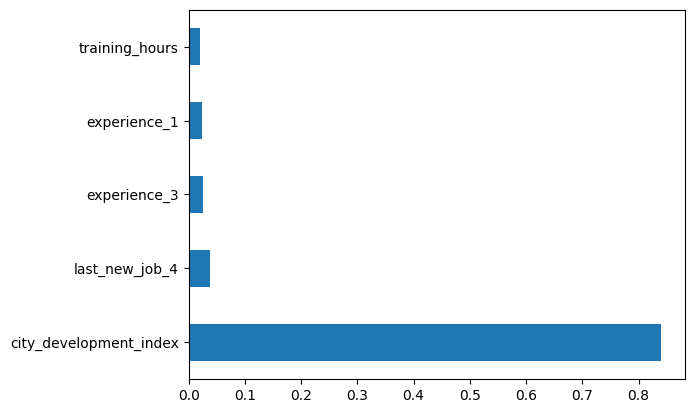

In [18]:
weights = model_dt.feature_importances_     # Feature importance scores.
cols = X.columns                            # Corresponding names of important features.
feature_importances = pd.Series(weights, index=cols)     # Generate Series containing importance level
print(feature_importances)

# Plot the five most important features 
feature_importances.nlargest(5).plot(kind="barh")

# Visualize the tree.

In [20]:
# Visualize the tree. Note: to run dot command, we have to install '`graphviz'
from sklearn import tree
tree.export_graphviz(decision_tree=model_dt, out_file='classification-tree.dot', feature_names=X.columns)     # Save model as 'classification-tree.dot'
from subprocess import call
call(['dot', '-Tpng', 'classification-tree.dot', '-o', 'classification-tree.png', '-Gdpi=300'])        # Convert the model to an image

0

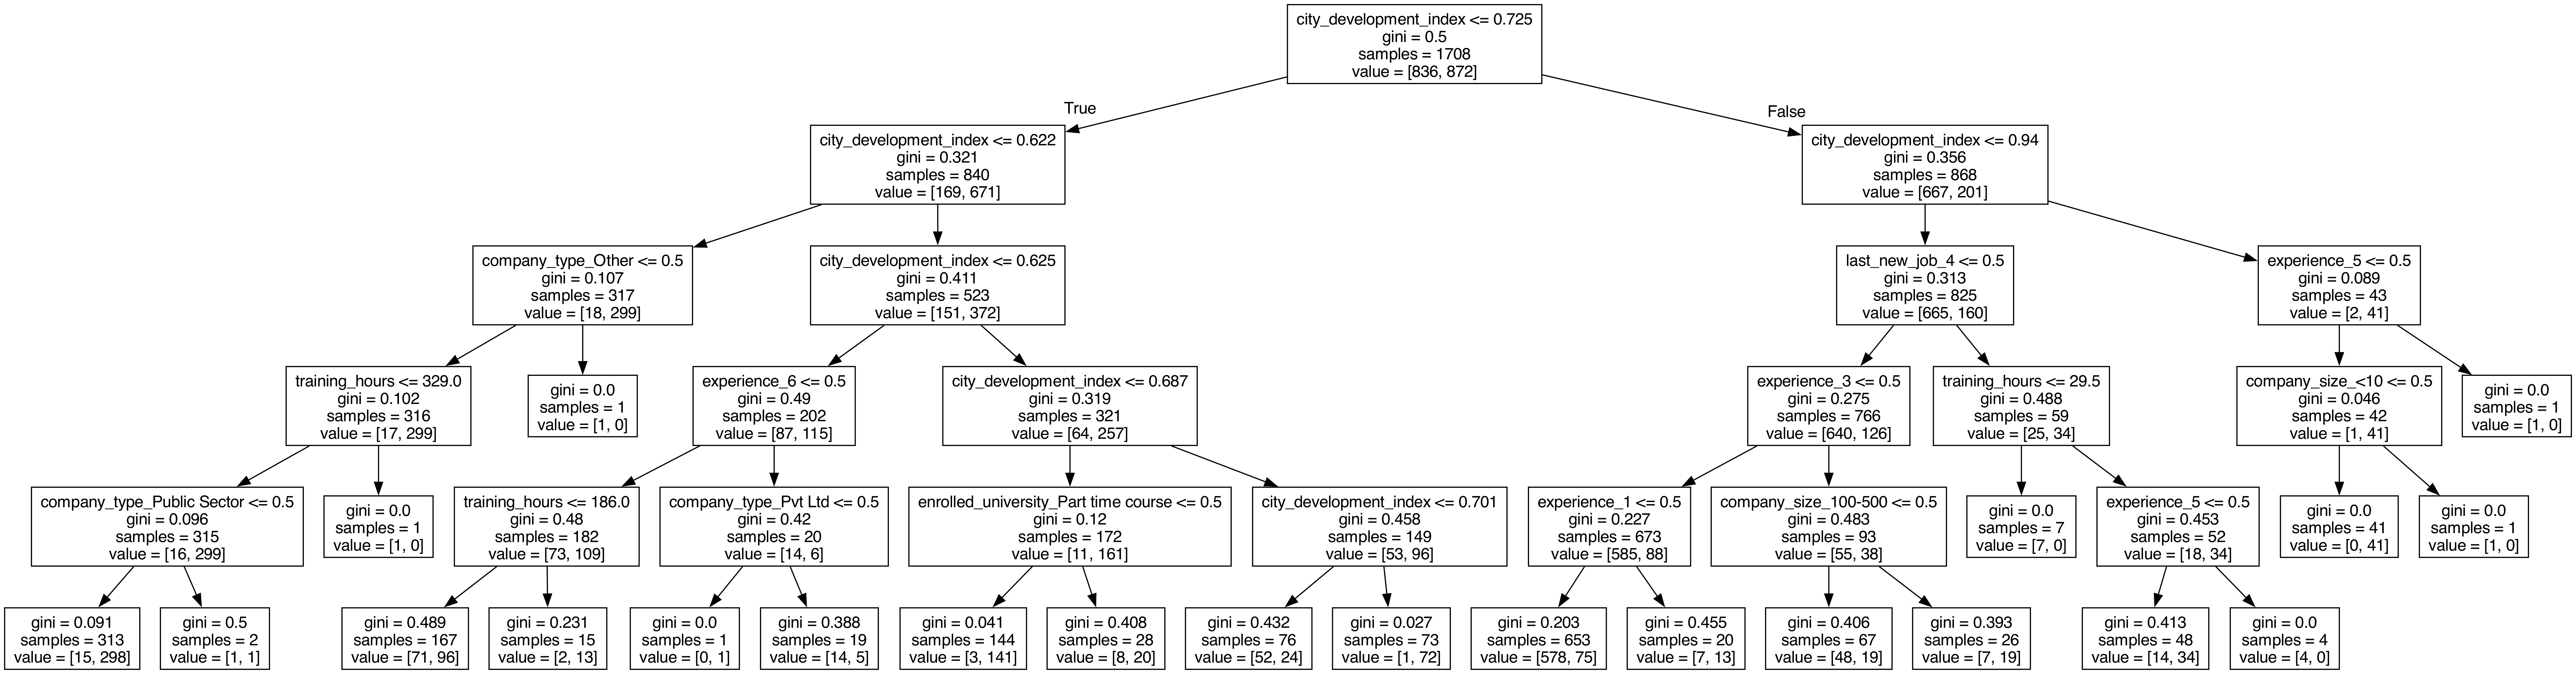

In [21]:
from IPython.display import Image
Image(filename = 'classification-tree.png')     # Load and display file 'classification-tree.png'